In [1]:
import os
import numpy
import numpy.random

import torch
import torch.distributions.constraints as constraints

import pyro
from pyro import sample, param
from pyro.optim import SGD, Adam
from pyro.infer import EmpiricalMarginal, Importance, SVI, TraceGraph_ELBO
from pyro.infer.mcmc import MCMC, HMC
from pyro.distributions import Exponential, Bernoulli, Gamma, LogNormal, Normal, Poisson

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pyro.enable_validation(True)

Simulated data:

In [3]:
TOTAL_PAGE_COUNT = 10
PAGES_PER_SESSION_PRIOR = 5
NUMBER_OF_SESSIONS = 100

DECAY = 2.

# Simulate some trend
TREND = PAGES_PER_SESSION_PRIOR * numpy.exp(- numpy.arange(NUMBER_OF_SESSIONS) * DECAY 
                                            / NUMBER_OF_SESSIONS) 
         

# Sample data around the trend
DATA = numpy.minimum(TOTAL_PAGE_COUNT, 
                          numpy.maximum(1, 
                                        numpy.round(numpy.random.exponential(TREND))))

print("Trend from {:.2f} to {:.2f}".format(TREND[0], TREND[-1]))
print("Data:", DATA)

Trend from 5.00 to 0.69
Data: [ 3.  6. 10.  1.  1.  3.  1.  3.  1.  1. 10.  6.  6.  4.  3.  2.  5.  3.
 10. 10.  1.  1.  1.  5.  1.  1.  3.  6.  1.  2.  3. 10.  8.  1.  2.  3.
  1.  4.  3.  6.  3.  1.  5.  2.  1.  2.  2.  1.  1.  2.  2.  1.  5.  3.
  2.  1.  1.  1.  3.  1.  3.  1.  1.  2.  2.  2.  1.  1.  1.  1.  1.  2.
  1.  1.  3.  1.  1.  1.  1.  1.  1.  2.  1.  2.  1.  3.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  2.  1.  1.  1.]


Let's define the model of clicking through a campaign:

In [4]:
PERSISTENT = False

def persistent_update_beliefs(beliefs, i, j, bandwidth):
    update = torch.zeros(beliefs.shape)
    update[i, j] = 1
    beliefs = beliefs + update
    evidence = beliefs[i, :].sum()
    if evidence > bandwidth:
        scale = torch.ones(beliefs.shape)
        scale[i, :] = bandwidth / evidence
        beliefs = beliefs * scale
    return beliefs


def fast_update_beliefs(beliefs, i, j, bandwidth):
    beliefs[i, j] += 1
    evidence = beliefs[i, :].sum()
    if evidence > bandwidth:
        beliefs[i, :] *= bandwidth / evidence
    return beliefs
        
    
def model(total_page_count, data):
    update_beliefs = persistent_update_beliefs if PERSISTENT \
        else fast_update_beliefs
    bandwidth = pyro.sample("bandwidth", Exponential(torch.tensor(0.05)))
    churn_probability = 1 / PAGES_PER_SESSION_PRIOR
    churn_beliefs = torch.stack([2 * churn_probability * torch.ones(total_page_count - 1),
                                 2 * (1 - churn_probability) * torch.ones(total_page_count - 1)],
                                dim=1)

    for (id, pps) in enumerate(data):
        for ip in range(total_page_count - 1):
            a, b = churn_beliefs[ip]
            dist = Bernoulli(probs=a/(a + b))
            if ip == int(pps) - 1:
                # churned out
                sample("obs_{}_{}".format(id, ip), dist, obs=torch.tensor(1.))
                churn_beliefs = update_beliefs(churn_beliefs, ip, 0, bandwidth)
                break
            else:
                # stayed 
                sample("obs_{}_{}".format(id, ip), dist, obs=torch.tensor(0.))
                churn_beliefs = update_beliefs(churn_beliefs, ip, 1, bandwidth)

## Importance sampling

Slow but should work.

In [5]:
N = 1000
def sample_posterior(model, n=N):
    posterior = Importance(model, num_samples=n)
    marginal = EmpiricalMarginal(posterior.run(TOTAL_PAGE_COUNT, DATA), 
                                     sites="bandwidth")
    bandwidth_samples = [marginal().item() for _ in range(n)]
    return bandwidth_samples

PERSISTENT = False
CPU times: user 1min 10s, sys: 1.15 s, total: 1min 11s
Wall time: 1min 13s
11.2673 3.2339
PERSISTENT = True
CPU times: user 1min 7s, sys: 918 ms, total: 1min 7s
Wall time: 1min 9s
11.1048 3.1593


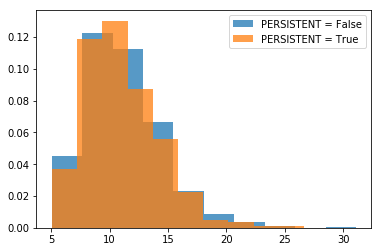

In [6]:
for p in [False, True]:
    global PERSISTENT
    PERSISTENT = p
    label = "PERSISTENT = {}".format(PERSISTENT)
    print(label)
    %time imp_bandwidth_samples = sample_posterior(model)
    plt.hist(imp_bandwidth_samples, density=True, label=label, alpha=0.75)
    print("{:.4f} {:.4f}"
          .format(numpy.mean(imp_bandwidth_samples),
                  numpy.std(imp_bandwidth_samples)))
plt.legend()

## NUTS (Hybrid Monte Carlo)

In [7]:
hmc_kernel = HMC(model)
mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(TOTAL_PAGE_COUNT, DATA)
posterior = EmpiricalMarginal(mcmc_run, 'bandwidth')
posterior.mean

ValueError: The parameter probs has invalid values

## Variational Inference

The guide (the posterior distribution of the bandwidth) is a Gamma distribution. We parameterize it by mean and standard deviation. It does not really matter how we parameterize it except for ease of convergence. This works well:

In [ ]:
def guide(total_page_count, data):
    mu = pyro.param("mu", torch.tensor(20.0), 
                    constraint=constraints.positive)
    sigma = pyro.param("sigma", torch.tensor(5.0),
                       constraint=constraints.positive)
    alpha = mu*mu / (sigma * sigma)
    beta = alpha / mu
    pyro.sample("bandwidth", Gamma(alpha, beta))

In [ ]:
optim_params = {"lr": 0.01}
optimizer = Adam(optim_params)

# setup the inference algorithm
svi = SVI(model, guide=guide, optim=optimizer, loss=TraceGraph_ELBO())

# clear the param store
pyro.clear_param_store()
losses = []

In [ ]:
# do gradient steps
PERSISTENT = True
best_mu = None
best_sigma = None
min_loss = numpy.nan
for step in range(100):
    loss = svi.step(TOTAL_PAGE_COUNT, DATA)
    losses.append(loss)
    if not (loss >= min_loss):
        best_mu = pyro.param("mu").item()
        best_sigma = pyro.param("sigma").item()
        print("{:4d}: loss={:.1f} => {:.1f} mean={:.4f} std={:.4f}"
              .format(step + 1, min_loss, loss, best_mu, best_sigma))
        min_loss = loss
    else:
        print("{:4d}: loss={:.1f} mean={:.4f} std={:.4f}"
              .format(step + 1, min_loss, best_mu, best_sigma), end="\r")


In [ ]:
# set the best parameters
pyro.clear_param_store()
pyro.param("mu", torch.tensor(best_mu))
pyro.param("sigma", torch.tensor(best_sigma))

In [ ]:
WINDOW = len(losses) // 10
plt.plot([numpy.mean(losses[i:i + WINDOW]) for i in range(len(losses) - WINDOW)])

In [ ]:
svi_bandwidth_samples = sample_posterior(guide)
plt.hist(imp_bandwidth_samples, density=True, label="Importance", alpha=0.75)
plt.hist(svi_bandwidth_samples, density=True, label="SVI", alpha=0.75)
plt.legend()
print("{:.4f} {:.4f}"
      .format(numpy.mean(svi_bandwidth_samples),
              numpy.std(svi_bandwidth_samples)))